In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/BikeSharingAssignment-LinearRegression

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/BikeSharingAssignment-LinearRegression


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df_bike = pd.read_csv("day.csv")
df_bike['dteday'] = pd.to_datetime(df_bike['dteday'])
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [4]:
df_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
df_bike.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
instant,730.0,365.500000,210.877136,1.000000,8.290000,37.450000,73.900000,183.250000,365.500000,547.750000,657.100000,693.550000,722.710000,730.000000
season,730.0,2.498630,1.110184,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,1.000000,1.000000,2.000000,4.000000,7.000000,10.000000,11.000000,12.000000,12.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,6.000000,6.000000,6.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,5.985470,8.747024,10.653165,13.811885,20.465826,26.880615,29.998347,31.520460,33.868050,35.328347
atemp,730.0,23.726322,8.150308,3.953480,7.290493,11.030712,12.752280,16.889713,24.368225,30.445775,33.908210,35.749975,38.941650,42.044800


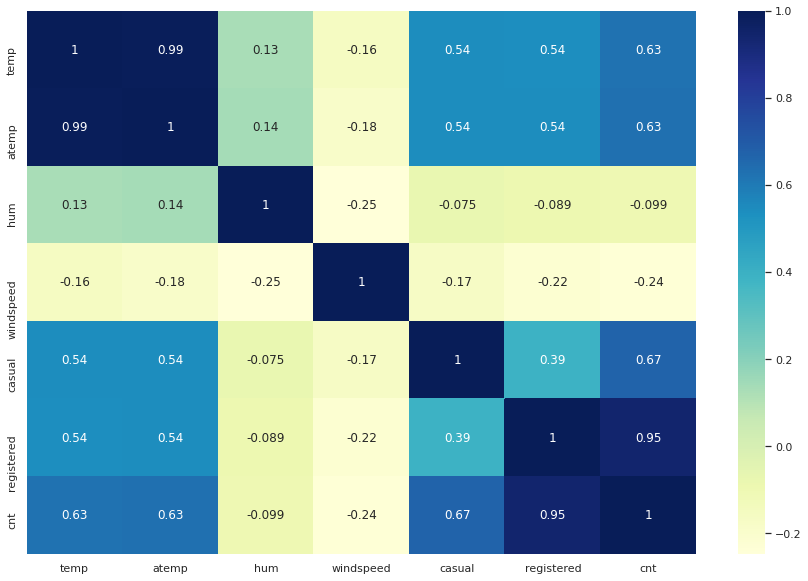

In [6]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (15, 10))
sns.heatmap(df_bike[["temp","atemp","hum","windspeed","casual", "registered","cnt"]].corr(), annot = True, cmap="YlGnBu")
plt.show()

Since "registered" and "casual" add up to make the target ("cnt"), we cannot use these in building the model as they would not be available ahead of time.



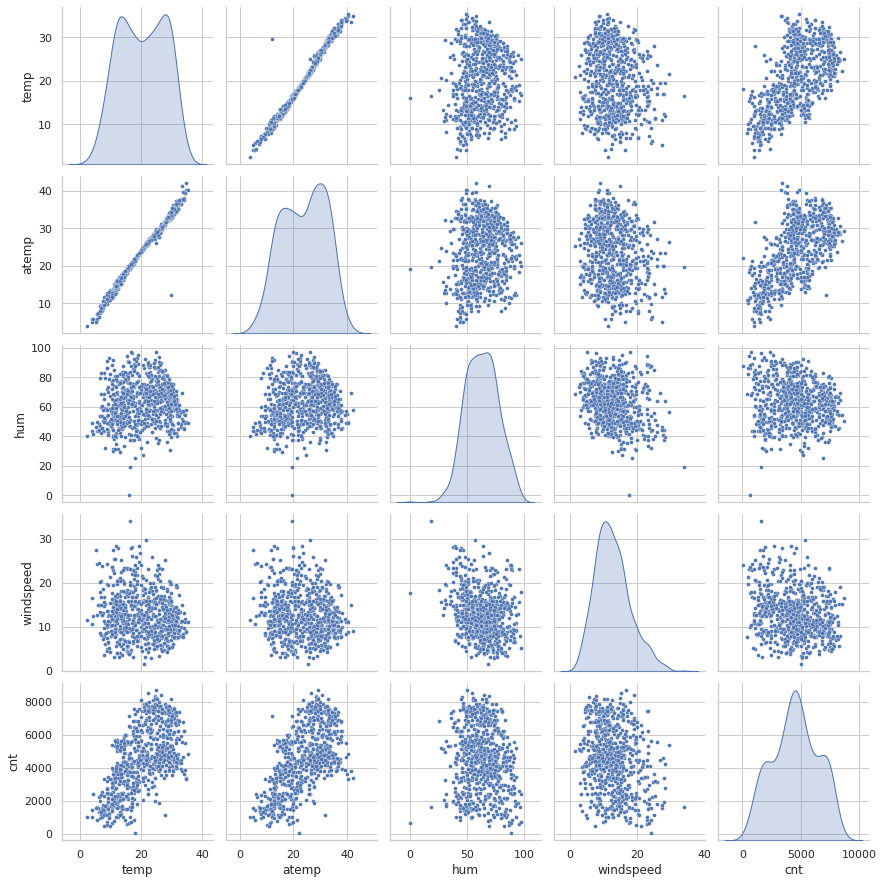

In [7]:
# Plotting pairplots to check correlations between numeric varibales
sns.pairplot(df_bike[["temp","atemp","hum","windspeed","cnt"]], plot_kws={"s": 15}, diag_kind='kde')

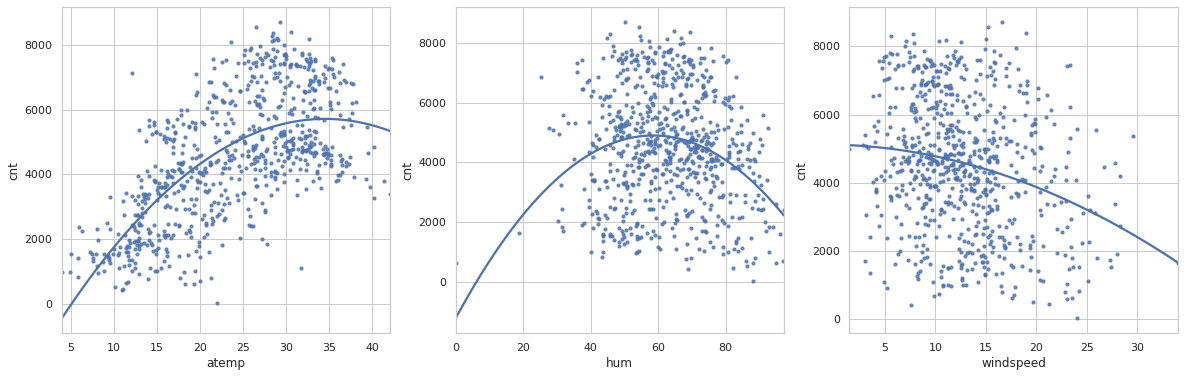

In [8]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.regplot(x="atemp", y="cnt", data=df_bike,
                 scatter_kws={"s": 10},
                 order=2, ci=None)
plt.subplot(1,3,2)
sns.regplot(x="hum", y="cnt", data=df_bike,
                 scatter_kws={"s": 10},
                 order=2, ci=None)
plt.subplot(1,3,3)
sns.regplot(x="windspeed", y="cnt", data=df_bike,
                 scatter_kws={"s": 10},
                 order=2, ci=None)


*   The relationship between "atemp" and "cnt" looks quadratic. Similarly, the relationship between "hum" and "cnt" also seems quadratic
*   While the relationship between "windspeed" and "cnt" seems mostly linear
*   Hence we will also be adding squared terms for "atemp" and "hum"


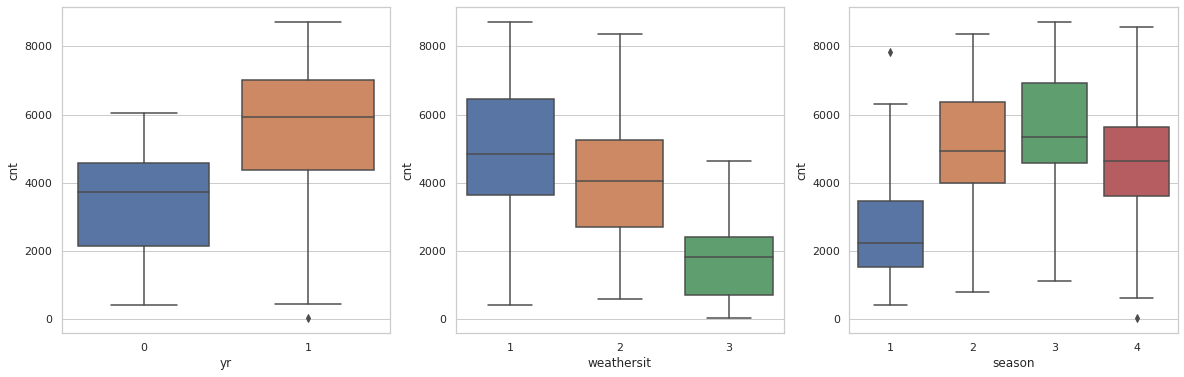

In [9]:
# Plotting box plots for categorical variables

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot(x = "yr", y = "cnt", data = df_bike)
plt.subplot(1,3,2)
sns.boxplot(x = "weathersit", y = "cnt", data = df_bike)
plt.subplot(1,3,3)
sns.boxplot(x = "season", y = "cnt", data = df_bike)


*   Year: The median count in 2019 is significantly higher than that of 2018

*   Weather Situation: The median count during light precipitation is significantly lower than that of cloudy or clear weather

*  Season: During winter the median count is the lowest compared to other seasons







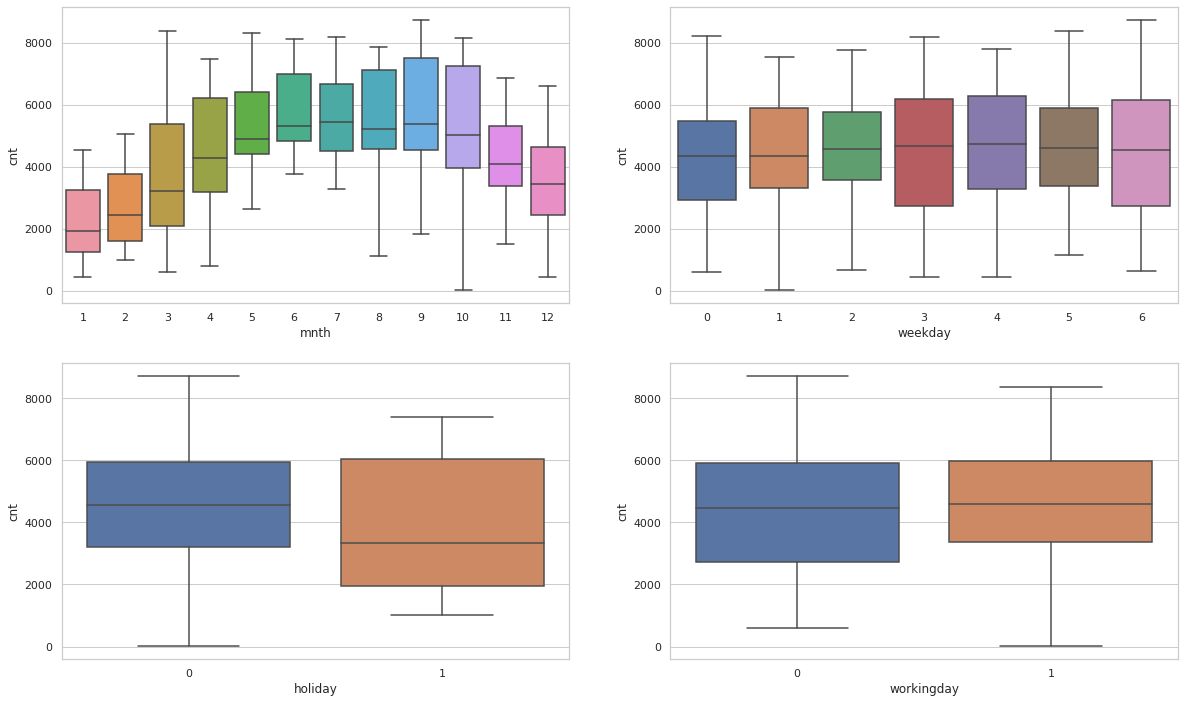

In [10]:
# Plotting box plots for categorical variables 
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.boxplot(x = "mnth", y = "cnt", data = df_bike)
plt.subplot(2,2,2)
sns.boxplot(x = "weekday", y = "cnt", data = df_bike)
plt.subplot(2,2,3)
sns.boxplot(x = "holiday", y = "cnt", data = df_bike)
plt.subplot(2,2,4)
sns.boxplot(x = "workingday", y = "cnt", data = df_bike)



*   Month: Winter months (Dec,Jan,Feb, Mar) have the lowest median count
*   Weekday: The median count does not show much variation between the days of the week. All days have a median slightly above 4000

*   Holiday: The median count during holiday is lower than that of during no holiday
*   Working Day: The median count does not show much variation between working vs non-working days





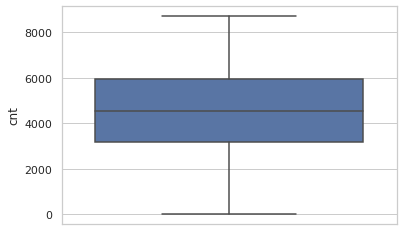

In [11]:
sns.boxplot(y = "cnt", data = df_bike) 


*   The median of the target(cnt) is somewhere between 4000 and 5000
*   The target(cnt) does not seem to have any outliers



Fin!